Using MDAnalysis version 2.8.0


quin fitxer de molecules vols analitzar?  9dcb-pdb-bundle1.pdb


624 5
576 11
1176 8
432 8
72 6
600 9
576 9
960 4
192 10
360 8
672 8
336 9
312 8
696 11
936 7
936 6
1200 7
312 14
648 12
792 7
624
576
1176
432
72
600
576
960
192
360
672
336
312
696
936
936
1200
312
648
792


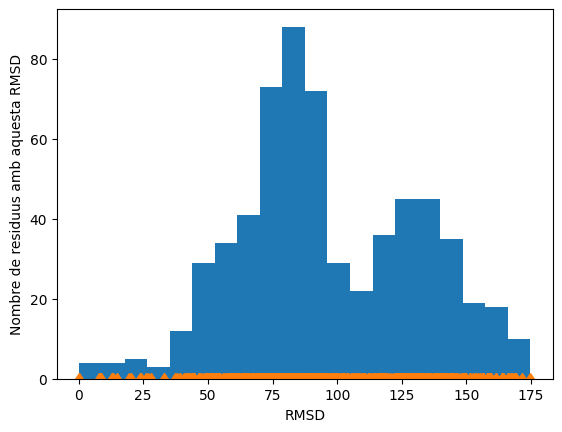

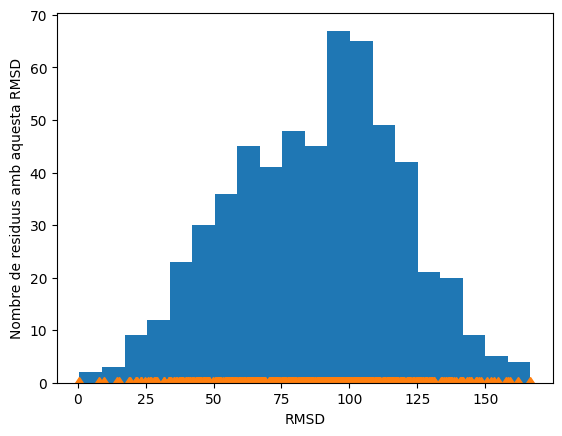

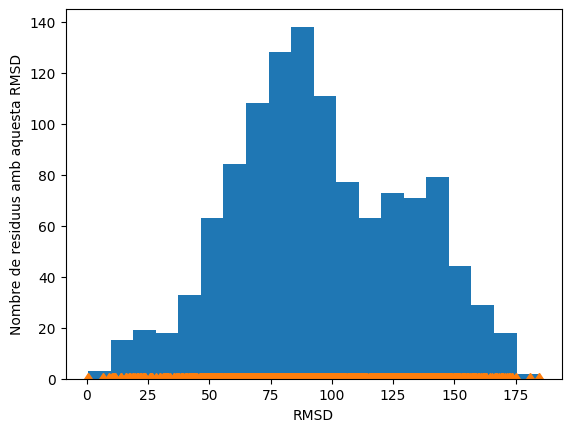

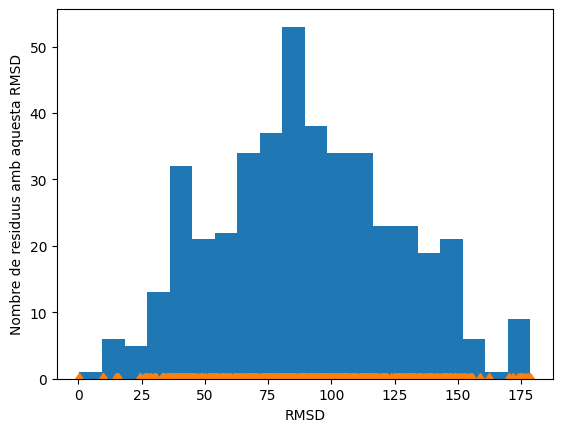

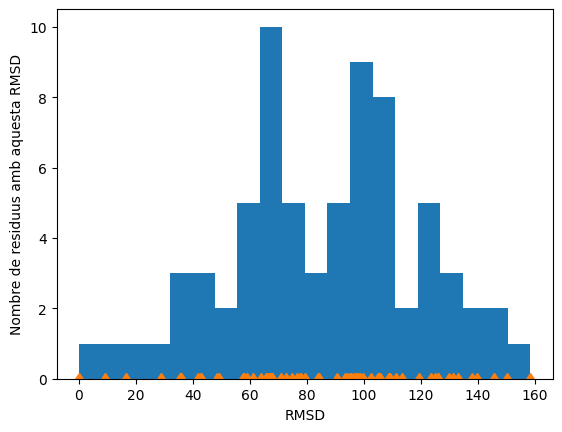

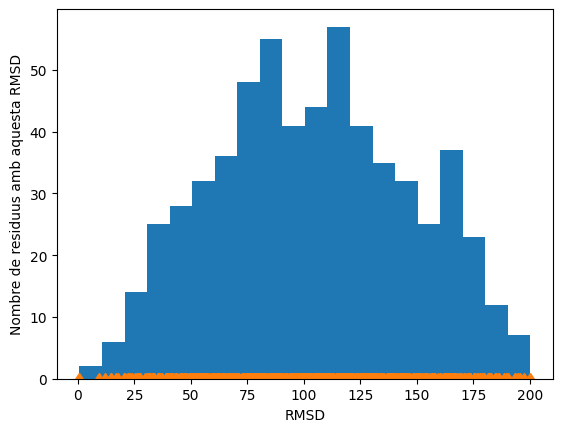

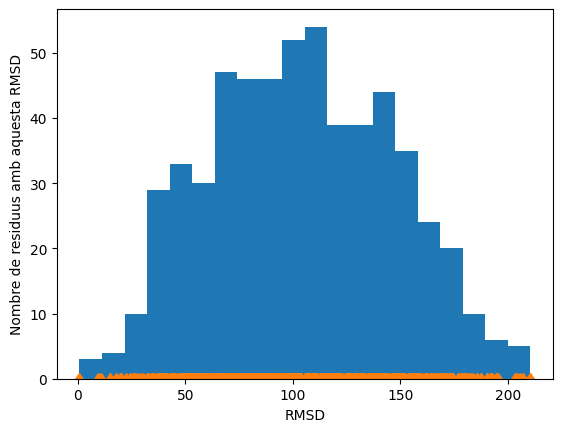

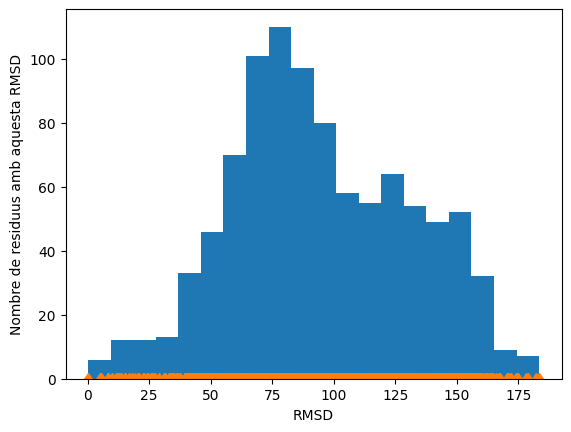

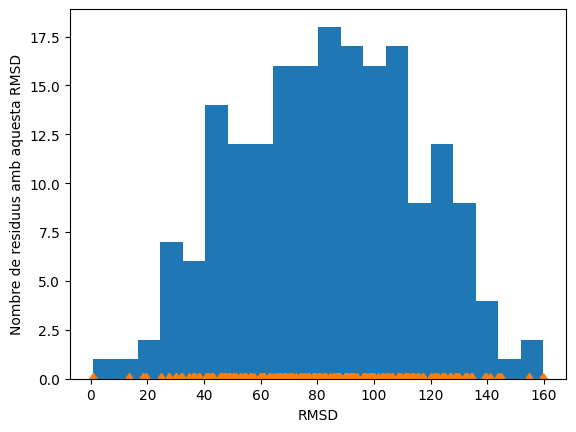

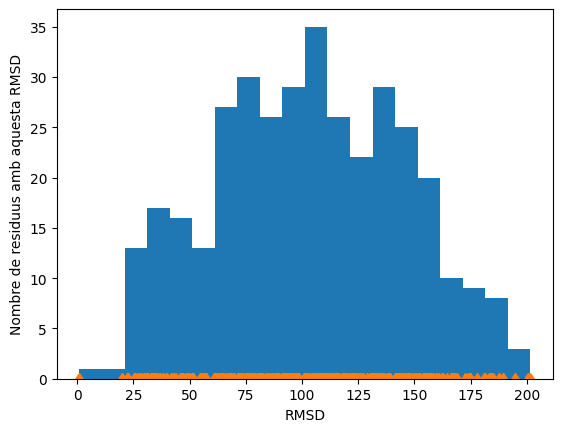

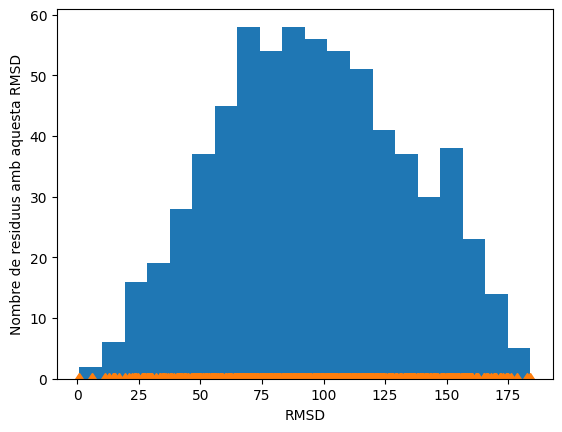

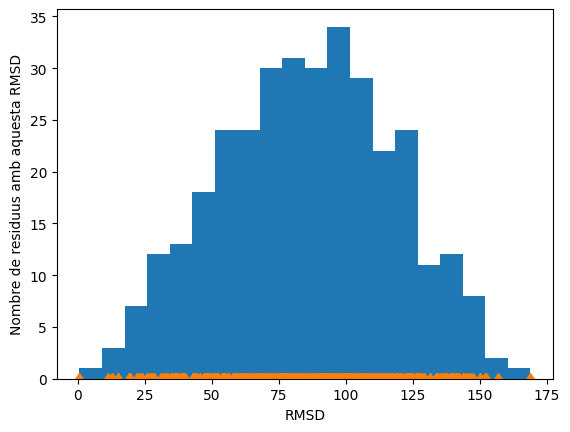

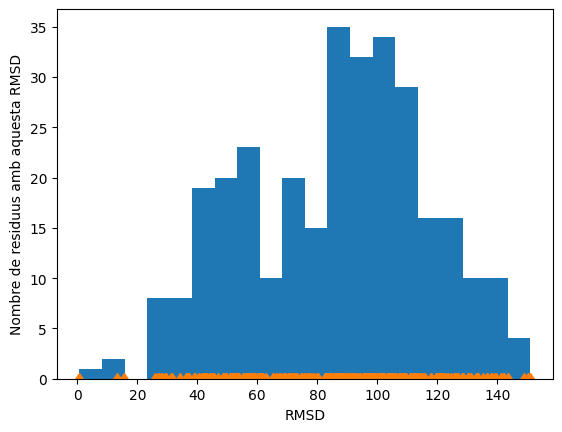

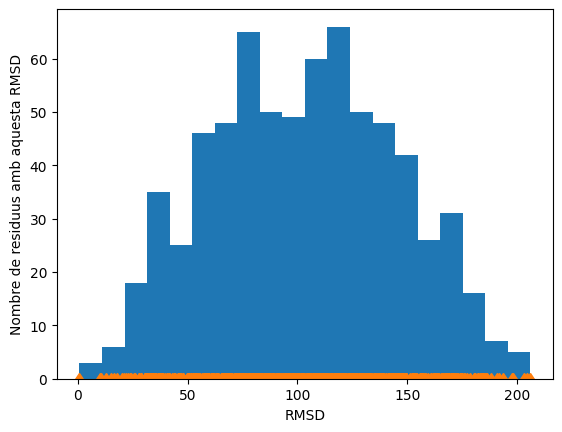

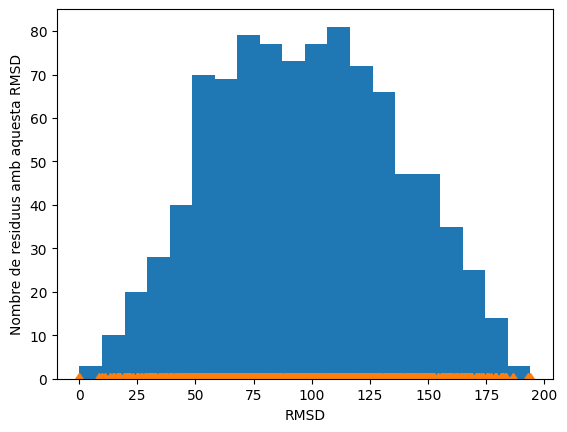

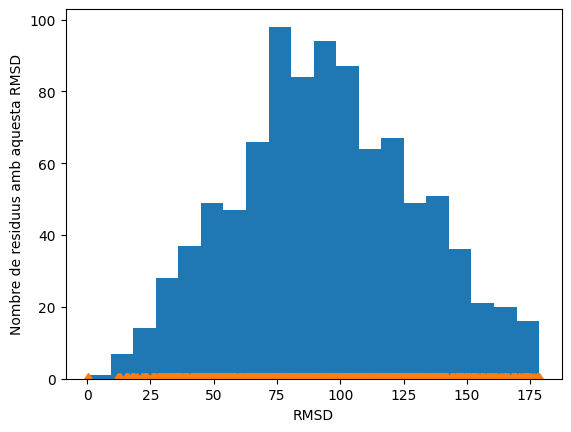

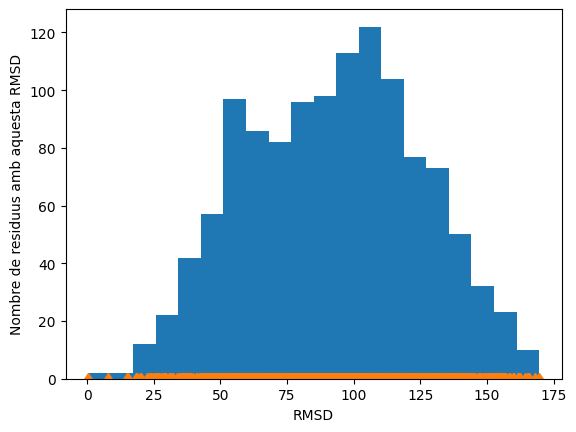

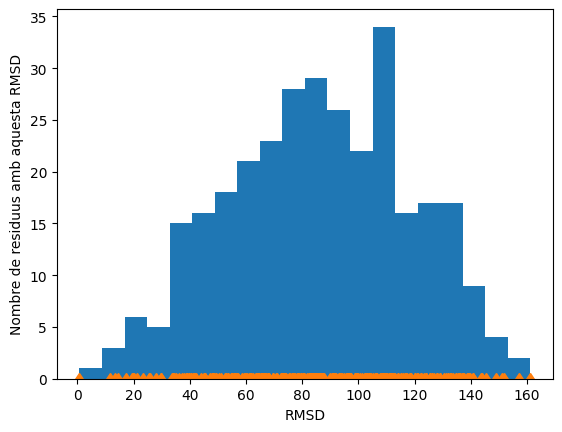

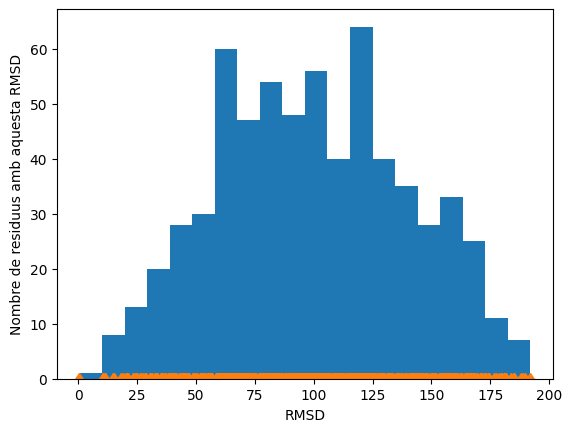

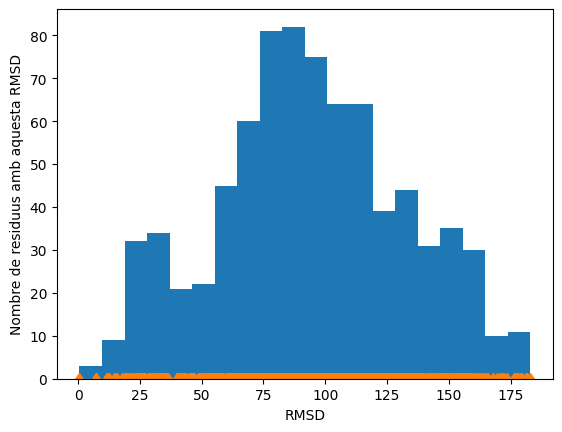

In [97]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os

warnings.filterwarnings('ignore') # suppress some MDAnalysis warnings about PSF files
print("Using MDAnalysis version", mda.__version__)


aminoacids = [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", 
    "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
]
results_folder = "resultats"
data_folder = "dades"
molecule_file = input("quin fitxer de molecules vols analitzar? ")
molecule_name = molecule_file.split(".")[0]

def folder_check(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

folder_check(results_folder)
folder_check(results_folder + "/" + molecule_name)

#funcions definides

def histogram(hist_data, hist_name):
    """
    prints and saves a histogram with the given distribution
    """
    hist_data = np.array(hist_data)
    
    fig, ax = plt.subplots()
    ax.hist(hist_data, bins )
    # plot the xdata locations on the x axis:
    ax.plot(hist_data, 0*hist_data, 'd' )
    ax.set_ylabel('Nombre de residuus amb aquesta RMSD')
    ax.set_xlabel('RMSD')


def average_structure(av_residu, av_univers):
    """
    For a given aminoacid and a universe, returns the average shape of that aminoacid in the universe
    """
    av_univers = av_univers.select_atoms("protein and resname "+av_residu)
    n_frames = len(av_univers.residues)
    if n_frames ==0:
        return
    n_atoms = len(av_univers.residues[0].atoms)
    print(n_frames, n_atoms)
    
    with mda.Writer(results_folder + "/" + molecule_name+ "/" +av_residu +'.xtc', n_atoms) as w:
        for ts in range(n_frames):
            if len(av_univers.residues[ts].atoms)== n_atoms:
                w.write(av_univers.residues[ts].atoms)
            else: print(ts, "té algun problema a la " + av_residu)
    av_univers=mda.Universe(results_folder + "/" + molecule_name+ "/"+av_residu +'.xtc')
    average = align.AverageStructure(av_univers,
                                     ref_frame=0).run()
    ref = average.results.universe
    ref.atoms.write(results_folder + "/" + molecule_name+ "/" + av_residu +"average.pdb")

def distortion_distribution(dist_univers, dist_residu, dist_reference):
    """
    for a given aminoacid it calclates the RMSD 
    """
    dist_univers = dist_univers.select_atoms("resname "+dist_residu)
    distribution= []
    for res_i in dist_univers.residues:
        distribution.append( mda.analysis.rms.rmsd(dist_reference.positions, res_i.atoms.positions))
    histogram(distribution, dist_residu)
    print(len(distribution))
    
def max_list(m_list, m_select):
    """
    Given a list of tuples it returns the one that has the max value at a given position
    """
    m_max= m_list[0]
    for element in m_list:
        if element[m_select]>m_max[m_select]:
            m_max = element
    return m_max

def n_alpha_dist(protein):
    """
    For a given protein, it returns the distance between the c_alpha atom and its -COO atached carbon for each residue
    """
    if not isinstance(protein, mda.core.universe.Universe):
        raise TypeError(f"Expected input_value to be of type mda.core.universe.Universe, but got {type(protein).__name__}")
    distances = []
    for res in protein.residues:
        nitrogen = res.atoms.select_atoms("name N")
        carbon_a = res.atoms.select_atoms("name CA")
        if len(nitrogen) == 1 and len(carbon_a) == 1:
            distance = np.linalg.norm(nitrogen.positions[0] - carbon_a.positions[0])
            distances.append((res.resid, res.resname, distance))
        else:
            print(f"Skipping residue {res.resid} ({res.resname}) due to lacking infotmation")
    return distances


###Main

u = mda.Universe(data_folder+"/"+molecule_file)
#Es determinen les estructures mitjanes
for aminoacid in aminoacids:
    average_structure(aminoacid, u)
#Es determinen les RMSD respecte les estructures mitjanes

for aminoacid in aminoacids:
    distortion_distribution(u, aminoacid, mda.Universe(results_folder + "/" + molecule_name+ "/" + aminoacid +"average.pdb").atoms)


In [5]:
distancies = n_alpha_dist(u)
residues = u.residues
print(distancies[0])

Text(0.5, 0, 'x bins (dx=1.0)')

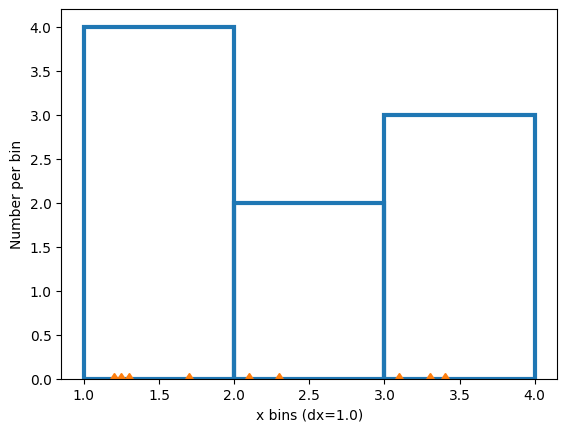

In [71]:
rng = np.random.default_rng(19680801)

xdata = np.array([1.2, 2.3, 3.3, 3.1, 1.7, 3.4, 2.1, 1.25, 1.3])
xbins = np.array([1, 2, 3, 4])

# changing the style of the histogram bars just to make it
# very clear where the boundaries of the bins are:
style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 3}

fig, ax = plt.subplots()
ax.hist(xdata, bins=xbins, **style)

# plot the xdata locations on the x axis:
ax.plot(xdata, 0*xdata, 'd')
ax.set_ylabel('Number per bin')
ax.set_xlabel('x bins (dx=1.0)')

(np.int64(1), 'MET', np.float32(1.4755622))
u 2
